In [1]:
!pip install pyspark
!pip install matplotlib
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as sf
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression

plt.rcParams['figure.figsize'] = (14,7)

In [3]:
# Creating a Spark Session
spark = SparkSession.builder.appName("homework").getOrCreate()

df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Data/data.csv", inferSchema = True, header = True)
df.printSchema()
df.count()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



229990

In [4]:
df.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|5331-RGMTT|  Male|          1.0|    Yes|        No|  54.0|  

In [5]:
df.select([sf.count(sf.when(sf.isnan(col) | sf.col(col).isNull(), col)).alias(col) for col in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

In [6]:
df = df.dropDuplicates().na.drop()
df.count()

7038

In [7]:
def get_list_of(feature, step=1):
  return [item[0] for idx, item in enumerate(df.select(feature).collect()) if idx % step == 0]

# Feature Analysis & Selection

In [8]:
df = df.drop("customerID")

## Convert Categorical data to numerical data

In [9]:
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if not item[1].startswith('string')]

In [10]:
df_origin = df
indexer = StringIndexer(inputCols=cat_cols, outputCols=[col + "Index" for col in cat_cols])
df = indexer.fit(df).transform(df).drop(*cat_cols)
df = df.select([sf.col(col).alias(col.replace("Index", "")) for col in df.columns])
df = df.withColumnRenamed("gender", "Gender").withColumnRenamed("tenure", "Tenure")

In [11]:
df_origin.show()

+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|
+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+
|Female|          0.0|    Yes|       Yes|  69.0|         Yes|             Yes|    Fiber optic|

In [12]:
df.show()

+-------------+------+--------------+------------+------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+-----+
|SeniorCitizen|Tenure|MonthlyCharges|TotalCharges|Gender|Partner|Dependents|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|Label|
+-------------+------+--------------+------------+------+-------+----------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+-----+
|          0.0|  69.0|        113.25|     7895.15|   1.0|    1.0|       1.0|         0.0|          1.0|            0.0|           1.0|         1.0|             1.0|        1.0|        1.0|            1.0|     1.0|             1.0|          3.0|  0

### Removing Outlayers

In [13]:
df_before = df

for col in df.columns:
  df_origin.groupBy(col, 'Label').count().show()

+-------------+-----+-----+
|SeniorCitizen|Label|count|
+-------------+-----+-----+
|         17.0|   No|    1|
|         14.0|  Yes|    2|
|          1.0|  Yes|  476|
|          0.0|   No| 4496|
|          1.0|   No|  666|
|          0.0|  Yes| 1391|
|         14.0|   No|    6|
+-------------+-----+-----+

+------+-----+-----+
|Tenure|Label|count|
+------+-----+-----+
|  56.0|  Yes|   10|
|  48.0|   No|   55|
|  33.0|   No|   50|
|  57.0|   No|   57|
|  66.0|  Yes|   13|
|-586.0|   No|    1|
|  43.0|  Yes|   15|
|  51.0|  Yes|    8|
|  62.0|  Yes|    5|
|   6.0|  Yes|   40|
|  64.0|   No|   76|
|  24.0|   No|   71|
|  18.0|   No|   73|
|  59.0|   No|   52|
|  46.0|  Yes|   12|
|  22.0|   No|   61|
|  37.0|   No|   50|
|  60.0|  Yes|    6|
|  65.0|  Yes|    9|
|-593.0|  Yes|    1|
+------+-----+-----+
only showing top 20 rows

+--------------+-----+-----+
|MonthlyCharges|Label|count|
+--------------+-----+-----+
|         93.85|  Yes|    7|
|         54.55|  Yes|    2|
|          95.1|

### Fixing Outlayers

**Senior Citizen**

In [14]:
df = df.withColumn("SeniorCitizen", sf.when(sf.col("SeniorCitizen") >= 1, 1).otherwise(0))
df.groupBy("SeniorCitizen", 'Label').count().show()

+-------------+-----+-----+
|SeniorCitizen|Label|count|
+-------------+-----+-----+
|            1|  0.0|  673|
|            0|  0.0| 4496|
|            1|  1.0|  478|
|            0|  1.0| 1391|
+-------------+-----+-----+



**Tenure**

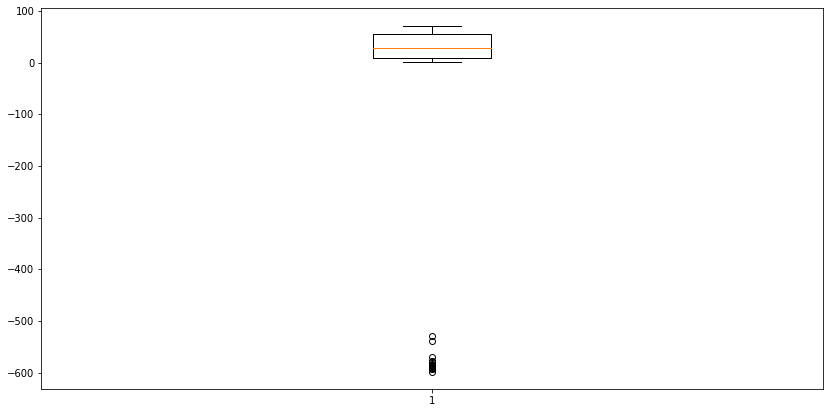

In [15]:
plt.boxplot(get_list_of("Tenure"))
plt.show()

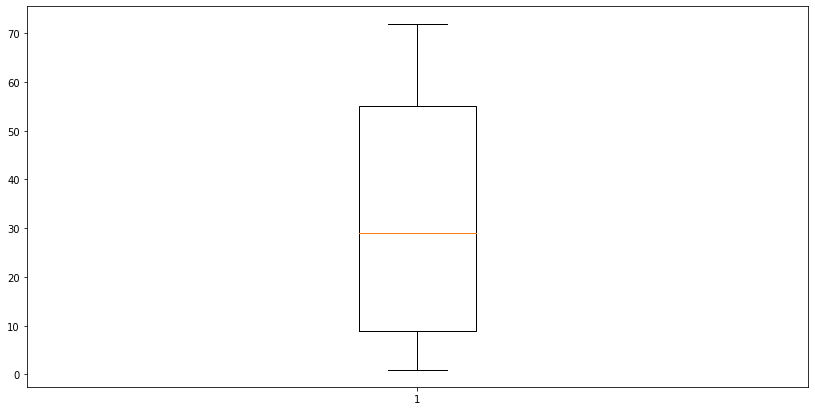

In [16]:
df = df.withColumn("Tenure", sf.when(sf.col("Tenure") < 0, 1).otherwise(df.Tenure))
plt.boxplot(get_list_of("Tenure"))
plt.show()

**Monthly Charges**

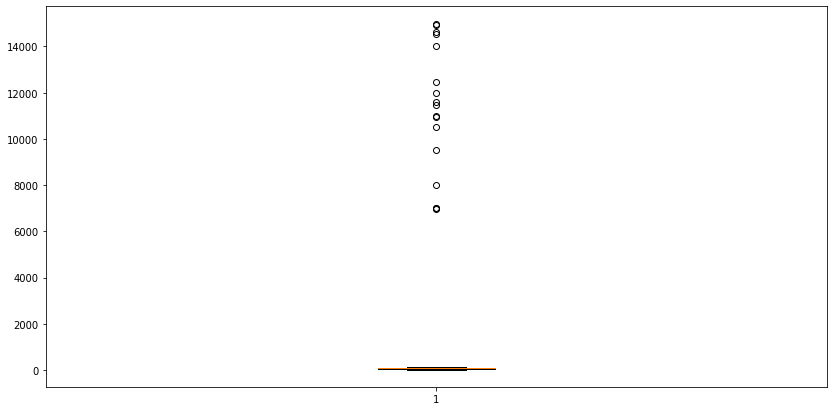

In [17]:
plt.boxplot(get_list_of("MonthlyCharges"))
plt.show()

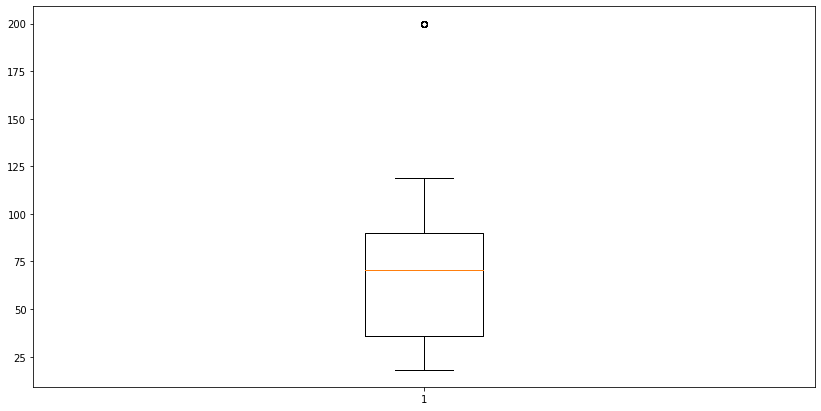

In [18]:
df = df.withColumn("MonthlyCharges", sf.when(sf.col("MonthlyCharges") >= 150, 200).otherwise(df.MonthlyCharges))
plt.boxplot(get_list_of("MonthlyCharges"))
plt.show()

### Calculating Correlation between each Feature and Label

In [19]:
corr_data = [(col, df.stat.corr(col, "Label")) for col in df.drop("Label").columns]
spark.createDataFrame(data=corr_data, schema=["Feature", "CorrelationWithLabel"]).show()

+----------------+--------------------+
|         Feature|CorrelationWithLabel|
+----------------+--------------------+
|   SeniorCitizen|   0.149916181595582|
|          Tenure|-0.35287991034498983|
|  MonthlyCharges| 0.18960681554936978|
|    TotalCharges|-0.19935232824570887|
|          Gender|0.008363964520041007|
|         Partner|-0.14974315544732092|
|      Dependents|-0.16290367899633013|
|    PhoneService|-0.01180271700716...|
|   MultipleLines|  0.0198141524680262|
| InternetService|-0.31623331275192157|
|  OnlineSecurity| -0.3321101128837582|
|    OnlineBackup|  -0.290813408175529|
|DeviceProtection| -0.2810766901842196|
|     TechSupport| -0.3291393374369222|
|     StreamingTV| -0.2050263376746268|
| StreamingMovies|-0.20666935906904116|
|        Contract|  -0.341280370375004|
|PaperlessBilling| -0.1915975504045214|
|   PaymentMethod|-0.26309882911077653|
+----------------+--------------------+



In [20]:
df.stat.corr("MonthlyCharges", "TotalCharges")
# high correlation, so we remove MonthlyCharges cuz Total Charges are a better overal feature

0.6350169484783788

In [21]:
# Removing features having correlation less than +-0.1 with Label
df = df.drop("MonthlyCharges", "Gender", "PhoneService", "MultipleLines")

### One-Hot Encoding Categorical Features

In [22]:
cat_cols = list(set(cat_cols).intersection(set(df.columns))) + ["SeniorCitizen"]
cat_cols.remove("Label")

In [23]:
df.show()

+-------------+------+------------+-------+----------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+-----+
|SeniorCitizen|Tenure|TotalCharges|Partner|Dependents|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|Label|
+-------------+------+------------+-------+----------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+-----+
|            0|  69.0|     7895.15|    1.0|       1.0|            0.0|           1.0|         1.0|             1.0|        1.0|        1.0|            1.0|     1.0|             1.0|          3.0|  0.0|
|            0|  60.0|      1128.1|    0.0|       0.0|            2.0|           2.0|         2.0|             2.0|        2.0|        2.0|            2.0|     1.0|             1.0|          2

In [24]:
encoder = OneHotEncoder(inputCols=cat_cols, outputCols=[col + "Hot" for col in cat_cols])
df = encoder.fit(df).transform(df).drop(*cat_cols)
df = df.select([sf.col(col).alias(col.replace("Hot", "")) for col in df.columns])
df.show()

+------+------------+-----+-------------+-------------+-------------+-------------+---------------+----------------+----------------+-------------+-------------+-------------+---------------+--------------+-------------+
|Tenure|TotalCharges|Label|PaymentMethod|     Contract|  TechSupport|      Partner|InternetService|DeviceProtection|PaperlessBilling|  StreamingTV| OnlineBackup|   Dependents|StreamingMovies|OnlineSecurity|SeniorCitizen|
+------+------------+-----+-------------+-------------+-------------+-------------+---------------+----------------+----------------+-------------+-------------+-------------+---------------+--------------+-------------+
|  69.0|     7895.15|  0.0|    (3,[],[])|(2,[1],[1.0])|(2,[1],[1.0])|    (1,[],[])|  (2,[0],[1.0])|   (2,[1],[1.0])|       (1,[],[])|(2,[1],[1.0])|(2,[1],[1.0])|    (1,[],[])|  (2,[1],[1.0])| (2,[1],[1.0])|(1,[0],[1.0])|
|  60.0|      1128.1|  0.0|(3,[2],[1.0])|(2,[1],[1.0])|    (2,[],[])|(1,[0],[1.0])|      (2,[],[])|       (2,[],[])|

In [25]:
print("Final Features Count:", len(df.columns) - 1)

Final Features Count: 15


# Model

## Creating Features Vector

In [46]:
assembler_cols = df.columns
assembler_cols.remove("Label")
vector_assembler = VectorAssembler(inputCols=assembler_cols, outputCol="Features")
model_df_before = vector_assembler.transform(df_before).select(sf.col("Features").alias("features"), sf.col("Label").alias("label"))
model_df_before.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[69.0,7895.15,3.0...|  0.0|
|[60.0,1128.1,2.0,...|  0.0|
|(15,[0,1,5,7,10,1...|  1.0|
|(15,[0,1,5,6,8,9,...|  1.0|
|[66.0,6891.45,0.0...|  0.0|
|[70.0,1411.2,3.0,...|  0.0|
|[72.0,8317.95,2.0...|  0.0|
|(15,[0,1,2,4,7,10...|  1.0|
|(15,[0,1,2,5,6,7,...|  0.0|
|[61.0,6993.65,1.0...|  0.0|
|[15.0,289.3,2.0,0...|  1.0|
|(15,[0,1,7,8],[42...|  0.0|
|(15,[0,1,6,11,12,...|  0.0|
|[71.0,6029.9,2.0,...|  0.0|
|[52.0,5621.85,0.0...|  0.0|
|(15,[0,1,2,6,7,8,...|  1.0|
|(15,[0,1,2,3,9,10...|  0.0|
|[38.0,743.05,1.0,...|  0.0|
|(15,[0,1,2,6,7],[...|  0.0|
|[33.0,2453.3,3.0,...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [47]:
assembler_cols = df.columns
assembler_cols.remove("Label")
vector_assembler = VectorAssembler(inputCols=assembler_cols, outputCol="Features")
model_df = vector_assembler.transform(df).select(sf.col("Features").alias("features"), sf.col("Label").alias("label"))
model_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(25,[0,1,6,8,10,1...|  0.0|
|(25,[0,1,4,6,9,19...|  0.0|
|(25,[0,1,2,5,7,10...|  1.0|
|(25,[0,1,2,5,7,11...|  1.0|
|(25,[0,1,2,7,10,1...|  0.0|
|(25,[0,1,6,14,24]...|  0.0|
|(25,[0,1,4,6,8,10...|  0.0|
|(25,[0,1,4,5,8,9,...|  1.0|
|(25,[0,1,5,7,11,1...|  0.0|
|(25,[0,1,3,8,9,10...|  0.0|
|(25,[0,1,4,5,9,19...|  1.0|
|(25,[0,1,2,5,7,9,...|  0.0|
|(25,[0,1,2,5,7,9,...|  0.0|
|(25,[0,1,4,6,8,11...|  0.0|
|(25,[0,1,2,7,10,1...|  0.0|
|(25,[0,1,5,7,9,11...|  1.0|
|(25,[0,1,3,7,9,10...|  0.0|
|(25,[0,1,3,6,9,19...|  0.0|
|(25,[0,1,5,7,9,11...|  0.0|
|(25,[0,1,7,11,13,...|  0.0|
+--------------------+-----+
only showing top 20 rows



## Spliting Data for Train & Test

In [48]:
train_before, test_before = model_df_before.randomSplit(weights=[0.8,0.2], seed=444)
train, test = model_df.randomSplit(weights=[0.8,0.2], seed=444)

## Creating and Training Models (before PreProcessing and after PreProcessing)

In [54]:
LR = LogisticRegression(maxIter=100, regParam=0.01)
LR.explainParams()

"aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)\nelasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)\nfamily: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)\nfeaturesCol: features column name. (default: features)\nfitIntercept: whether to fit an intercept term. (default: True)\nlabelCol: label column name. (default: label)\nlowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)\nlowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must be

In [55]:
model_before = LR.fit(train_before)
predection_before = model_before.transform(test_before)
predection_before.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(15,[0,1],[1.0,69...|  1.0|[-0.8453261370499...|[0.30041422511409...|       1.0|
|(15,[0,1],[1.0,69...|  1.0|[-0.8452390538132...|[0.30043252732578...|       1.0|
|(15,[0,1],[1.0,69...|  1.0|[-0.8451955121948...|[0.30044167867018...|       1.0|
|(15,[0,1],[1.0,69...|  1.0|[-0.8451519705764...|[0.30045083017362...|       1.0|
|(15,[0,1],[1.0,69...|  1.0|[-0.8451374567036...|[0.30045388071011...|       1.0|
|(15,[0,1],[1.0,69...|  1.0|[-0.8451229428309...|[0.30045693126427...|       1.0|
|(15,[0,1],[1.0,70...|  0.0|[-0.8449923179758...|[0.30048438704680...|       1.0|
|(15,[0,1],[1.0,74...|  1.0|[-0.8437876665344...|[0.30073765781604...|       1.0|
|(15,[0,1],[1.0,74...|  1.0|[-0.8436570416793...|[0.30076512822209...|       1.0|
|(15,[0,1],[1.0,

In [56]:
model = LR.fit(train)
predection = model.transform(test)
predection.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9923727762339...|[0.27044366475404...|       1.0|
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9923694123461...|[0.27044432846269...|       1.0|
|(25,[0,1,2,5,7,9,...|  0.0|[-0.9923635255424...|[0.27044548995531...|       1.0|
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9923576387388...|[0.27044665145106...|       1.0|
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9923475470754...|[0.27044864259394...|       1.0|
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9923391373559...|[0.27045030188672...|       1.0|
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9662859956335...|[0.27562140067051...|       1.0|
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9400133602325...|[0.28089764388680...|       1.0|
|(25,[0,1,2,5,7,9,...|  1.0|[-0.9394953215123...|[0.28100229655776...|       1.0|
|(25,[0,1,2,5,7,

## Evaluation

### Before PreProcessing

In [89]:
p_n, p_y = model_before.summary.precisionByLabel
r_n, r_y = model_before.summary.recallByLabel
f_n, f_y = model_before.summary.fMeasureByLabel()

print(f"Accuracy:\t {model_before.summary.accuracy * 100:.2f}%")
print(f"Precision for\t Yes: {p_y * 100:.2f}% \t No: {p_n * 100:.2f}%")
print(f"Recall for\t Yes: {r_y * 100:.2f}% \t No: {r_n * 100:.2f}%")
print(f"F-Measure for\t Yes: {f_y * 100:.2f}% \t No: {f_n * 100:.2f}%")

Accuracy:	 80.43%
Precision for	 Yes: 67.02% 	 No: 83.89%
Recall for	 Yes: 51.73% 	 No: 90.80%
F-Measure for	 Yes: 58.39% 	 No: 87.21%


### After PreProcessing

In [90]:
p_n, p_y = model.summary.precisionByLabel
r_n, r_y = model.summary.recallByLabel
f_n, f_y = model.summary.fMeasureByLabel()

print(f"Accuracy:\t {model.summary.accuracy * 100:.2f}%")
print(f"Precision for\t Yes: {p_y * 100:.2f}% \t No: {p_n * 100:.2f}%")
print(f"Recall for\t Yes: {r_y * 100:.2f}% \t No: {r_n * 100:.2f}%")
print(f"F-Measure for\t Yes: {f_y * 100:.2f}% \t No: {f_n * 100:.2f}%")

Accuracy:	 80.00%
Precision for	 Yes: 65.17% 	 No: 83.89%
Recall for	 Yes: 51.50% 	 No: 90.17%
F-Measure for	 Yes: 57.54% 	 No: 86.92%
